In [1]:
import numpy as np

In [2]:
TRAIN_DATA_POINTS = 270
TEST_DATA_POINTS = 370
N_CLASSES = 9
MAX_LENGTH = 29

In [3]:
from loadData import load_data

train_data = load_data("data/ae.train", num_data_points=TRAIN_DATA_POINTS, max_length=MAX_LENGTH)
test_data = load_data("data/ae.test", num_data_points=TEST_DATA_POINTS, max_length=MAX_LENGTH)

Maximum number of rows of all datapoints: 29
Successfully created a NumPy array with shape: (270, 29, 12)
Maximum number of rows of all datapoints: 29
Successfully created a NumPy array with shape: (370, 29, 12)


In [4]:
train_time_steps, channels = train_data.shape[1:]
test_time_steps = test_data.shape[1]

243


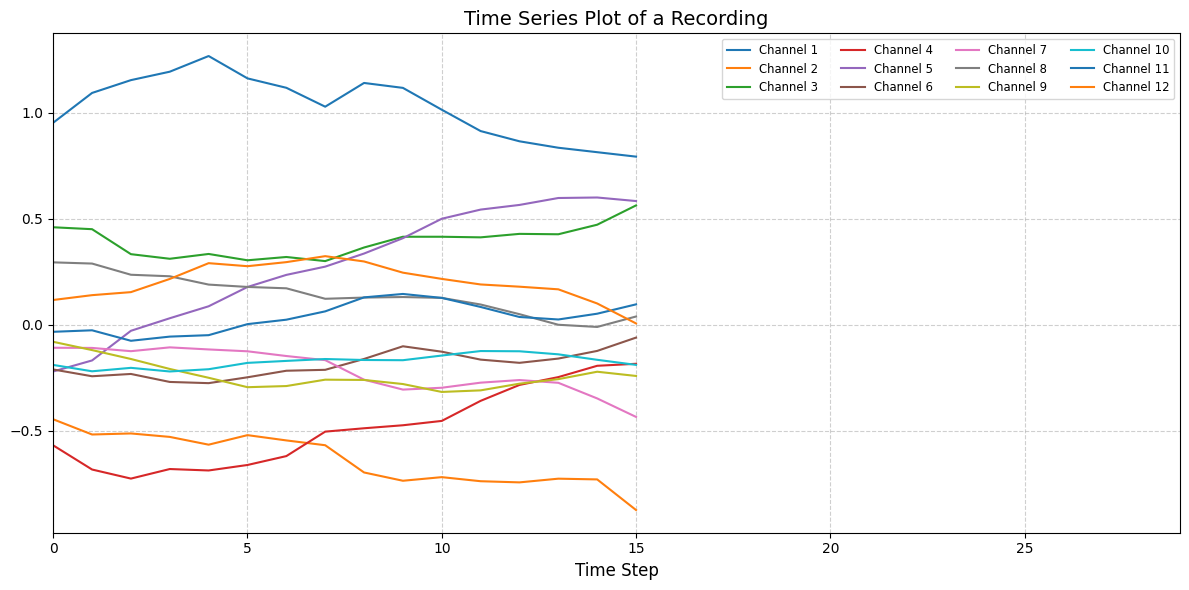

In [5]:
from visualizeData import visualize_data_point

data_idx = np.random.randint(0, TRAIN_DATA_POINTS)
print(data_idx)

visualize_data_point(train_data[data_idx])

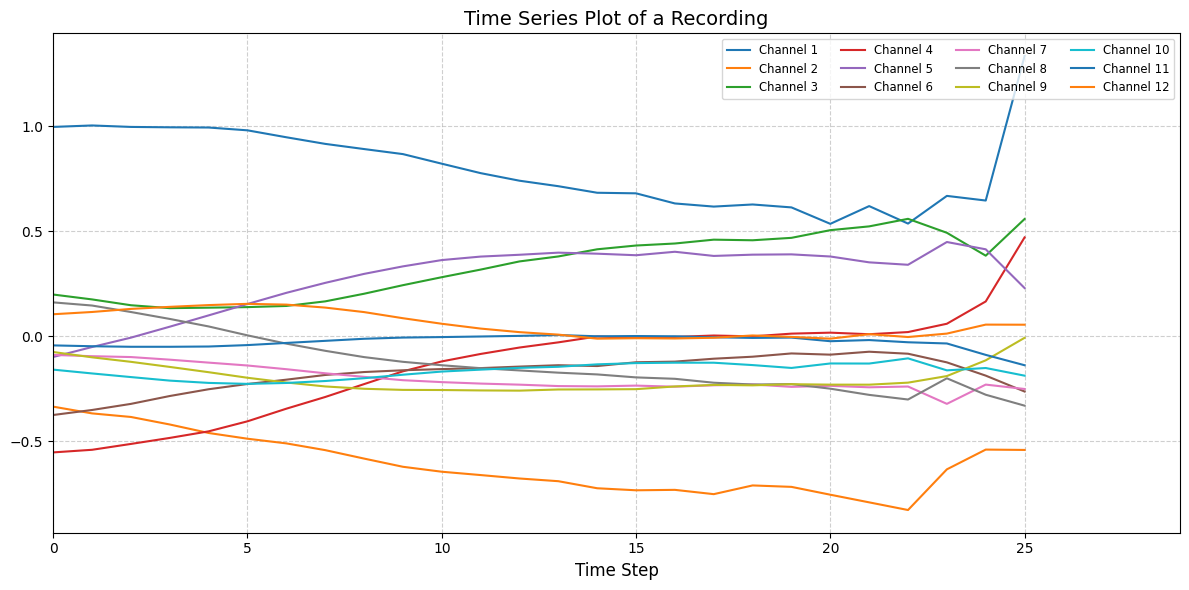

In [6]:
from processing import get_pattern_mean

pattern_mean = get_pattern_mean(train_data)
visualize_data_point(pattern_mean)

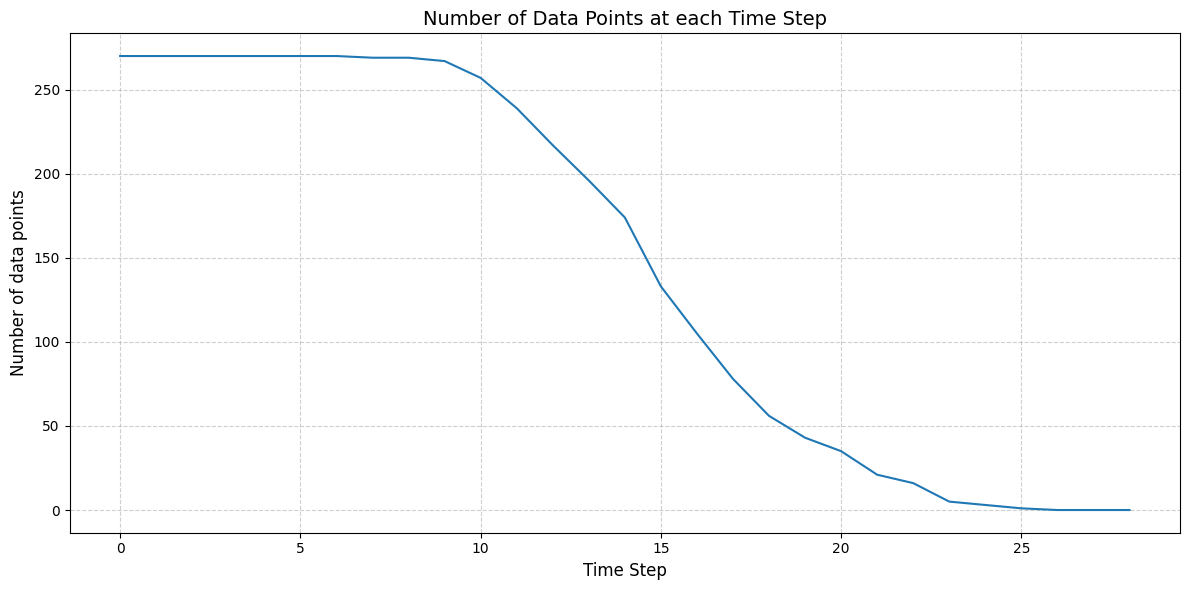

In [7]:
from processing import get_time_steps
from visualizeData import visualize_data_lengths

time_steps = get_time_steps(train_data)
visualize_data_lengths(time_steps)

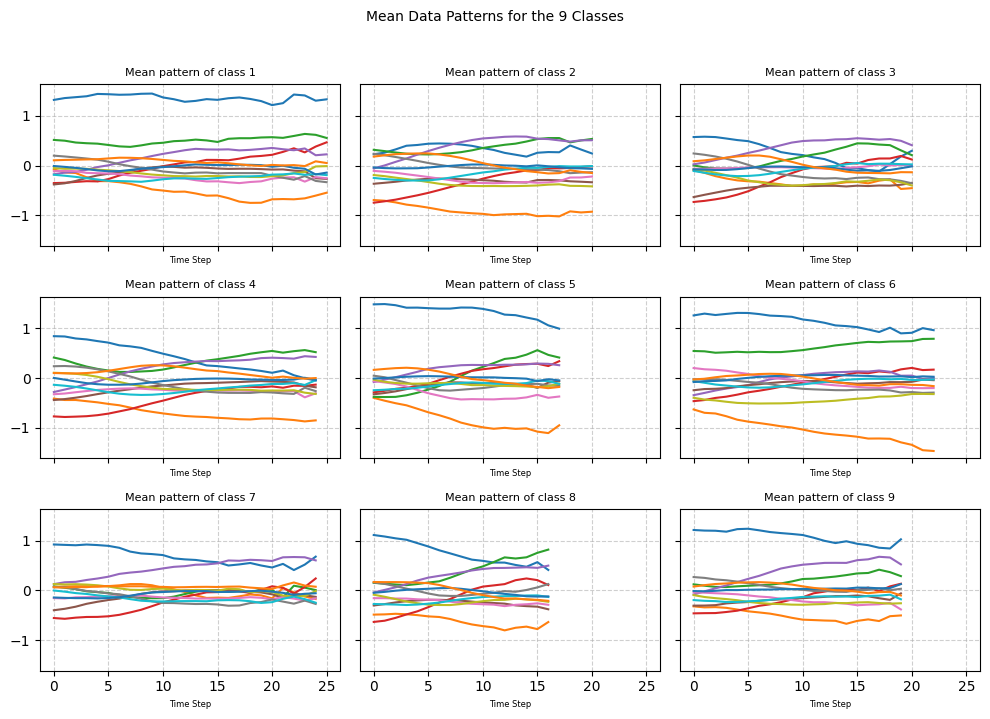

In [8]:
from visualizeData import visualize_class_means

visualize_class_means(train_data)

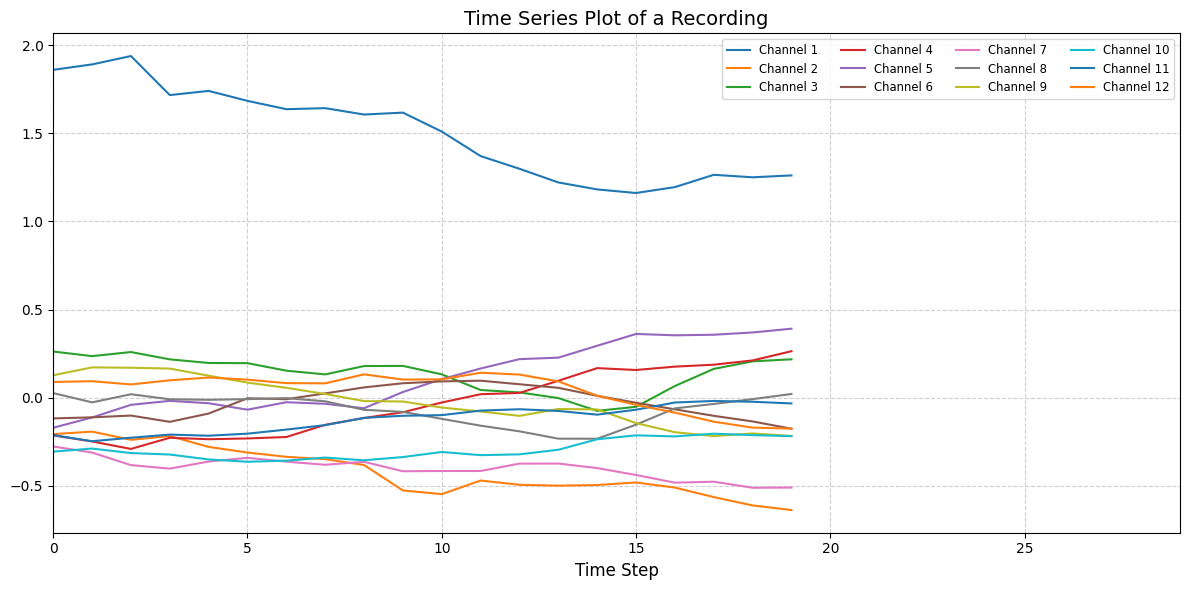

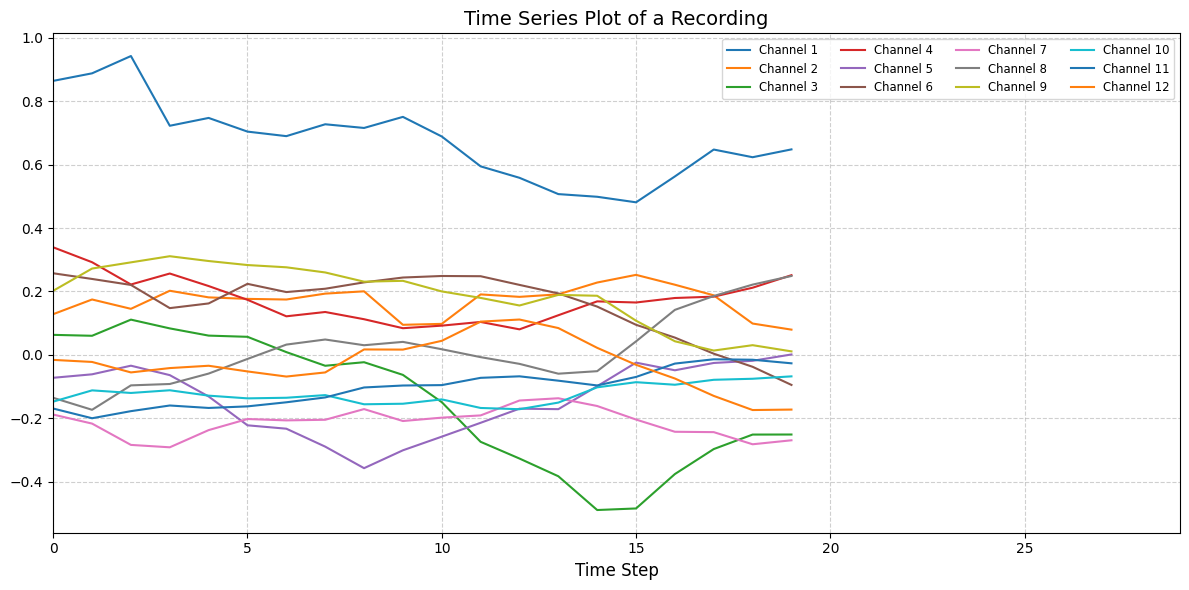

In [9]:
from processing import normalize

visualize_data_point(train_data[0])
# subtracting the mean
normalize(train_data, pattern_mean)
visualize_data_point(train_data[0])

In [10]:
from processing import flatten_data

flattend_data = flatten_data(train_data)
flattend_data.shape

(270, 348)

In [11]:
from processing import SVD

principal_components, feature_variances = SVD(flattend_data)

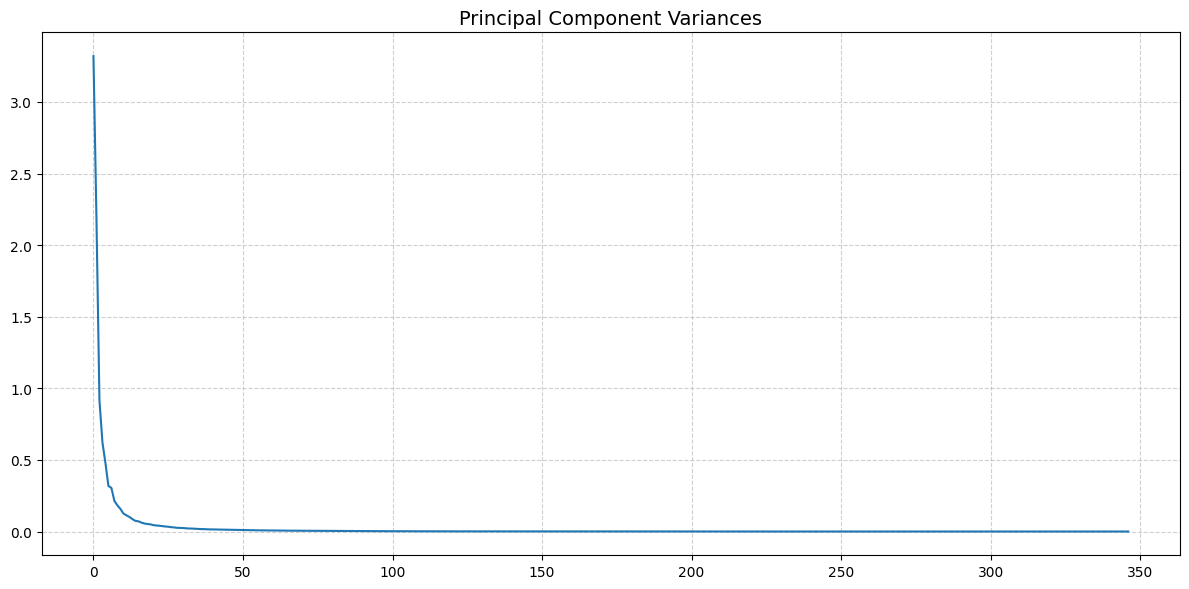

In [12]:
from visualizeData import visualize_PC_variance

visualize_PC_variance(feature_variances[:-1], log=False)

In [13]:
from processing import determine_cutoff

cutoff = determine_cutoff(feature_variances, wanted_variance=99)
cutoff

85

In [14]:
PCs_reduced = principal_components[:cutoff]
PCs_reduced.shape

(85, 348)

In [15]:
feature_vectors = np.matmul(flattend_data, PCs_reduced.transpose())
feature_vectors.shape

(270, 85)

In [ ]:
from processing import generate_class_matrix

class_matrix = generate_class_matrix(n_data_points=TRAIN_DATA_POINTS, n_classes=N_CLASSES)
class_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], shape=(270, 9))

In [17]:
from processing import compute_regression_classifier

regression_classifier = compute_regression_classifier(feature_vectors, class_matrix)
regression_classifier.shape

(85, 9)

In [18]:
from processing import compute_MSE

# mse on training data
train_mse = compute_MSE(regression_classifier, feature_vectors, class_matrix)
train_mse

np.float64(0.2936180513357518)

In [19]:
from processing import compute_mismatch

# mismatch on training data
train_misclassification_rate = compute_mismatch(regression_classifier, feature_vectors, class_matrix)
print("Mismatch: {:.2f}%".format(train_misclassification_rate * 100))

Mismatch: 1.11%


In [20]:
# subtracting the mean
normalize(test_data, pattern_mean)

In [21]:
test_flatten = flatten_data(test_data)
test_flatten.shape

(370, 348)

In [22]:
test_feature_vectors = np.matmul(test_flatten, PCs_reduced.transpose())
test_feature_vectors.shape

(370, 85)

In [23]:
from processing import generate_test_class_matrix

test_class_matrix = generate_test_class_matrix(n_data_points=TEST_DATA_POINTS, n_classes=N_CLASSES)
test_class_matrix.shape

(370, 9)

In [24]:
test_mse = compute_MSE(regression_classifier, test_feature_vectors, test_class_matrix)
test_mse

np.float64(0.467829700292818)

In [25]:
test_misclassification_rate = compute_mismatch(regression_classifier, test_feature_vectors, test_class_matrix)
print("Mismatch: {:.2f}%".format(test_misclassification_rate * 100))

Mismatch: 5.41%
